<a href="https://colab.research.google.com/github/nandrom/senalesIII/blob/main/FeatureExtraction_EMG_Signals_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.io import loadmat
!pip install antropy
ruta = '/content/drive/MyDrive/Señales 3/Notebooks/data/FeatureExtraction/'
data = loadmat(ruta+'S1_20140620T021349.mat')
data_ACC = data['data_ACC']
data_EMG = data['data_EMG']

In [ ]:
import scipy 
import numpy as np
from scipy import signal
import pywt
import matplotlib.pyplot as plt
from scipy.stats import entropy
import antropy as ant

fs = 4e3

def featureExtractionEMG(sampleSignal):
  # Esta función toma como argumento de entrada una señal EMG de 20000 muestras y retorna 13 caracteristicas relacionadas a la señal
  # a. Removemos el nivel DC
  nivelDC = np.mean(sampleSignal)
  sampleSignal = sampleSignal-nivelDC
  # b. Normalicemos las señales para que tengan amplitud unitaria
  maxSignal = np.abs(np.max(sampleSignal))
  sampleSignal = sampleSignal/maxSignal
  # Realicemos el análisis STFT
  f, t, Zxx = signal.stft(sampleSignal, fs, nperseg=512)

  rms = np.sqrt((np.sum(sampleSignal)**2)/len(sampleSignal))
  mae = np.sum(sampleSignal)/len(sampleSignal)
  # En la matriz Zxx se tiene una matriz de #defrecs * #times
# Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]
  absZxx = np.abs(Zxx)
  Pmax_Zxx = np.max(absZxx,axis=1) # dB

  Pmax_Zxx_dB = 20*np.log10(Pmax_Zxx)
  idx = np.argsort(Pmax_Zxx_dB)
  maximos = Pmax_Zxx_dB[idx]
  auxPotmax_Zxx = maximos[-5:]
  frecuencias = f[idx]
  fPmax_Zxx = frecuencias[-5:]
  #contador de cruces x cero
  zerocrosscont = 0
  for i in range (len(sampleSignal)-1):
    if (sampleSignal[i] > 0 and sampleSignal[i+1] < 0 or sampleSignal[i] < 0 and sampleSignal[i+1] > 0):
      zerocrosscont = zerocrosscont + 1
  feature_set = np.zeros((13,))
  feature_set[0] = rms
  feature_set[1] = mae
  feature_set[2:7] = auxPotmax_Zxx
  feature_set[7:12] = fPmax_Zxx
  feature_set[12] = zerocrosscont
  return feature_set

def calculate_entropy(list_values):
  entropyVal = ant.perm_entropy(list_values, normalize=True)
  return entropyVal

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  median = np.nanpercentile(list_values, 50)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.where(np.diff(np.signbit(list_values)))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.where(np.diff(np.signbit(list_values-np.nanmean(list_values))))[0]
  no_mean_crossings = len(mean_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = calculate_entropy(list_values)
  crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy] + crossings + statistics

In [ ]:
L_Signal, Classes, Ntrials = np.shape(data_EMG)
Features_Mat = np.zeros(((Ntrials)*Classes,13))
idx= 0
for i in range(Classes):
  for j in range(Ntrials):
    sampleSignal = data_EMG[:,i,j]
    Features_Mat[idx,:] = featureExtractionEMG(sampleSignal)
    idx = idx + 1

In [ ]:
import pandas as pd
Nombres = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero']

dataFrame = pd.DataFrame(data = Features_Mat, columns= Nombres)

In [ ]:
dataFrame

,RMS,MAE,P1,P2,P3,P4,P5,F1,F2,F3,F4,F5,Num Cruces Por Cero
0,9.640368e-16,-6.816769e-18,-23.555504,-23.144994,-22.141017,-21.858218,-20.953300,109.3750,70.3125,62.5000,46.8750,54.6875,1578.0
1,7.222425e-17,-5.107026e-19,-21.086336,-20.220955,-20.144087,-19.844343,-19.724684,101.5625,46.8750,93.7500,62.5000,54.6875,1272.0
2,3.768222e-16,2.664535e-18,-21.633771,-21.490314,-21.376370,-21.065010,-20.740075,109.3750,62.5000,101.5625,70.3125,78.1250,1217.0
3,8.729714e-16,6.172840e-18,-20.278898,-19.938039,-19.766401,-19.335561,-18.570395,93.7500,78.1250,62.5000,46.8750,70.3125,1251.0
4,7.662051e-16,5.417888e-18,-19.416449,-19.050366,-18.806421,-18.668377,-17.773824,101.5625,109.3750,46.8750,78.1250,93.7500,1282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,5.514165e-15,3.899103e-17,-19.644577,-18.501406,-13.545892,-10.585466,-9.307036,85.9375,31.2500,39.0625,54.6875,46.8750,773.0
1130,2.600073e-15,1.838529e-17,-23.586442,-21.904199,-17.892399,-10.021839,-9.074029,31.2500,62.5000,39.0625,54.6875,46.8750,660.0
1131,2.951774e-16,-2.087219e-18,-19.941411,-19.417816,-18.516005,-12.465656,-11.446678,31.2500,62.5000,39.0625,54.6875,46.8750,899.0
1132,8.415696e-16,-5.950795e-18,-20.160685,-20.052003,-19.059053,-11.320301,-9.996900,31.2500,101.5625,39.0625,54.6875,46.8750,899.0


TypeError: ignored

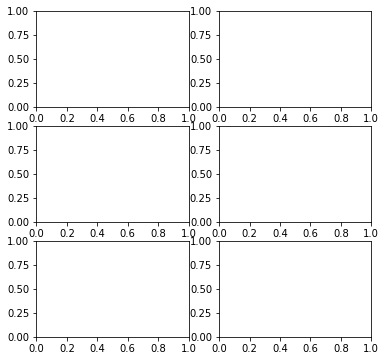

In [ ]:
nDesc = 3
waveletname = 'sym'+str(nDesc)
 
fig, axarr = plt.subplots(nrows=nDesc, ncols=2, figsize=(6,6))
for ii in range(nDesc):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    # extraer las D (inicialmente 22) caracteristicas a la variable data
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [ ]:
Features_Mat_Wt = np.zeros((Ntrials*Classes*nDesc,12*nDesc))

In [ ]:
# Extraccion de caracteristicas de las Wavelet
nDesc = 3
waveletname = 'sym'+str(nDesc)
Features_Mat_Wt = np.zeros((Ntrials*Classes,12*(nDesc+1))) # +1 para incluir los coeficioentes definidos de la 1er Wt
idx= 0
for i in range(Classes):
  for j in range(Ntrials):
    sampleSignal = data_EMG[:,i,j]
    for ii in range(nDesc):
      (sampleSignal, coeff_d) = pywt.dwt(sampleSignal, waveletname)
      if ii==0:
        Features_Mat_Wt[idx,ii*12:(ii+1)*12] = get_features(sampleSignal)
        Features_Mat_Wt[idx,12*nDesc:] = get_features(coeff_d)
      else:  
        Features_Mat_Wt[idx,ii*12:(ii+1)*12] = get_features(sampleSignal)
    idx = idx + 1

In [ ]:
Nombres = ['Entropy_Wt1','no_zero_crossings_Wt1','no_mean_crossings_Wt1','n5_Wt1', 'n25_Wt1', 'n75_Wt1', 'n95_Wt1', 'median_Wt1', 'mean_Wt1', 'std_Wt1', 'var_Wt1', 'rms_Wt1','Entropy_Wt2','no_zero_crossings_Wt2','no_mean_crossings_Wt2','n5_Wt2', 'n25_Wt2', 'n75_Wt2', 'n95_Wt2', 'median_Wt2', 'mean_Wt2', 'std_Wt2', 'var_Wt2', 'rms_Wt2','Entropy_Wt3','no_zero_crossings_Wt3','no_mean_crossings_Wt3','n5_Wt3', 'n25_Wt3', 'n75_Wt3', 'n95_Wt3', 'median_Wt3', 'mean_Wt3', 'std_Wt3', 'var_Wt3', 'rms_Wt3', 'Entropy_coeff1','no_zero_crossings_coeff1','no_mean_crossings_coeff1','n5_coeff1', 'n25_coeff1', 'n75_coeff1', 'n95_coeff1', 'median_coeff1', 'mean_coeff1', 'std_coeff1', 'var_coeff1', 'rms_coeff1']

dataFrame2 = pd.DataFrame(data = Features_Mat_Wt, columns= Nombres)
dataFrame2

In [ ]:
Features_Mat_Full = np.concatenate((Features_Mat,Features_Mat_Wt),axis=1)
Nombres = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero','Entropy_Wt1','no_zero_crossings_Wt1','no_mean_crossings_Wt1','n5_Wt1', 'n25_Wt1', 'n75_Wt1', 'n95_Wt1', 'median_Wt1', 'mean_Wt1', 'std_Wt1', 'var_Wt1', 'rms_Wt1','Entropy_Wt2','no_zero_crossings_Wt2','no_mean_crossings_Wt2','n5_Wt2', 'n25_Wt2', 'n75_Wt2', 'n95_Wt2', 'median_Wt2', 'mean_Wt2', 'std_Wt2', 'var_Wt2', 'rms_Wt2','Entropy_Wt3','no_zero_crossings_Wt3','no_mean_crossings_Wt3','n5_Wt3', 'n25_Wt3', 'n75_Wt3', 'n95_Wt3', 'median_Wt3', 'mean_Wt3', 'std_Wt3', 'var_Wt3', 'rms_Wt3', 'Entropy_coeff1','no_zero_crossings_coeff1','no_mean_crossings_coeff1','n5_coeff1', 'n25_coeff1', 'n75_coeff1', 'n95_coeff1', 'median_coeff1', 'mean_coeff1', 'std_coeff1', 'var_coeff1', 'rms_coeff1']

CompletedataFrame = pd.DataFrame(data = Features_Mat_Full, columns= Nombres)
CompletedataFrame

In [ ]:
import seaborn as sns

sns.pairplot(CompletedataFrame, hue="Tipo Mov")